In [48]:
# Import Libraries
import os
import sys

import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd
import seaborn as sns
from uncertainties import ufloat
import warnings


# Add the src directory to the path to import snowpyt_mechparams
sys.path.append('../src')
from snowpilot_utils import parse_sample_pits


In [49]:
# Parse all snowpit files from the data folder
all_pits = parse_sample_pits('data')


Successfully parsed 50278 files
Failed to parse 0 files


In [50]:
# Collect General Pit Info
pit_info = []

for pit in all_pits:
    pit_info_dict = {
        # User info
        'pit_id': pit.core_info.pit_id,
        # Location info
        'pit_near_avalanche': pit.core_info.location.pit_near_avalanche,
        'pit_near_avalanche_location': pit.core_info.location.pit_near_avalanche_location if pit.core_info.location.pit_near_avalanche_location else None,
        # Weak Layer
        'identified_layer_of_concern': any(layer.layer_of_concern is True for layer in pit.snow_profile.layers) if pit.snow_profile.layers else None,
        # Stability Tests
        'num_CT': len(pit.stability_tests.CT),
        'num_ECT': len(pit.stability_tests.ECT),
        'num_PST': len(pit.stability_tests.PST),
        # Snowpit info

    }
    pit_info.append(pit_info_dict)
    
pit_df = pd.DataFrame(pit_info)

#print(pit_df.head())


In [51]:
## Summary Stats

# Total Pits
print(f"Total Pits: {len(pit_df)}")

# Number of Pits Near Avalanches
pits_near_avalanches = pit_df[(pit_df['pit_near_avalanche'] == True)]
print(f"Number of Pits Near Avalanches: {len(pits_near_avalanches)}")

# Number of Pits on Crowns
pits_on_crowns = pit_df[pit_df['pit_near_avalanche_location'] == 'crown']
print(f"Number of Pits on Crowns: {len(pits_on_crowns)}")

# Number of Pits on Flanks
pits_on_flanks = pit_df[pit_df['pit_near_avalanche_location'] == 'flank']
print(f"Number of Pits on Flanks: {len(pits_on_flanks)}")

# Number of Pits on Crowns and Flanks
print(f"Number of Pits on Crowns and Flanks: {len(pits_on_crowns) + len(pits_on_flanks)}")

# Number of pits with identified layer of concern
pits_with_layer_of_concern = pit_df[pit_df['identified_layer_of_concern'] == True]
print(f"Number of pits with identified layer of concern: {len(pits_with_layer_of_concern)}")

# Number of Pits with CT results
pits_with_CT_results = pit_df[pit_df['num_CT'] > 0]
print(f"Number of Pits with CT results: {len(pits_with_CT_results)}")

# Number of CT results 
print(f"Number of CT results: {sum(pit_df['num_CT'])}")

# Number of Pits with ECT results
pits_with_ECT_results = pit_df[pit_df['num_ECT'] > 0]
print(f"Number of Pits with ECT results: {len(pits_with_ECT_results)}")

# Number of ECT results
print(f"Number of ECT results: {sum(pit_df['num_ECT'])}")

# Number of Pits with PST results
pits_with_PST_results = pit_df[pit_df['num_PST'] > 0]
print(f"Number of Pits with PST results: {len(pits_with_PST_results)}")

# Number of PST results
print(f"Number of PST results: {sum(pit_df['num_PST'])}")


Total Pits: 50278
Number of Pits Near Avalanches: 1568
Number of Pits on Crowns: 795
Number of Pits on Flanks: 399
Number of Pits on Crowns and Flanks: 1194
Number of pits with identified layer of concern: 36408
Number of Pits with CT results: 28959
Number of CT results: 51599
Number of Pits with ECT results: 34327
Number of ECT results: 47684
Number of Pits with PST results: 5154
Number of PST results: 6213


## Dataset Construction and Analysis

This section constructs datasets efficiently and performs comprehensive analysis across all datasets.

In [52]:
# Helper functions for safe value extraction (used by both extraction functions)
def get_value_safe(obj):
    """Safely extract value from object that might be None, scalar, or array-like."""
    if obj is None:
        return None
    if isinstance(obj, (list, tuple, np.ndarray)):
        return obj[0] if len(obj) > 0 else None
    return obj

def extract_layer_dict(layer, pit_id, dataset_name):
    """
    Extract layer information into a dictionary.
    Shared by both layers of concern and failure layer extraction.
    """
    return {
        'pit_id': pit_id,
        'dataset': dataset_name,
        'depth_top': get_value_safe(layer.depth_top),
        'thickness': get_value_safe(layer.thickness),
        'hardness': layer.hardness if layer.hardness else None,
        'wetness': layer.wetness if layer.wetness else None,
        'grain_form_primary_grain_form': layer.grain_form_primary.grain_form if layer.grain_form_primary else None,
        'grain_from_primary_grain_size': get_value_safe(layer.grain_form_primary.grain_size_avg) if layer.grain_form_primary and layer.grain_form_primary.grain_size_avg else None,
        'grain_form_secondary_grain_form': layer.grain_form_secondary.grain_form if layer.grain_form_secondary else None,
        'grain_from_secondary_grain_size': get_value_safe(layer.grain_form_secondary.grain_size_avg) if layer.grain_form_secondary and layer.grain_form_secondary.grain_size_avg else None,
    }

def extract_layers_of_concern(pits, filter_location=None):
    """
    Efficiently extract all layers of concern from pits.
    
    Parameters:
    -----------
    pits : list
        List of pit objects
    filter_location : str, optional
        Filter by location: 'crown', 'flank', or None for all
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with layers of concern data
    """
    layers_of_concern = []
    dataset_name = filter_location if filter_location else 'all'
    
    for pit in pits:
        # Apply location filter if specified
        if filter_location and pit.core_info.location.pit_near_avalanche_location != filter_location:
            continue
        
        # Extract all layers of concern from this pit
        if pit.snow_profile.layers:
            for layer in pit.snow_profile.layers:
                if layer.layer_of_concern is True:
                    layers_of_concern.append(extract_layer_dict(layer, pit.core_info.pit_id, dataset_name))
    
    return pd.DataFrame(layers_of_concern)

def extract_layers_of_failure(pits, test):
    """
    Extract layers where a specific stability test type failed.
    
    Parameters:
    -----------
    pits : list
        List of pit objects
    test : str
        Test type: 'CT', 'ECT', or 'PST'
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with failure layers data for the specified test type
    """
    if test not in ['CT', 'ECT', 'PST']:
        raise ValueError(f"Invalid test type: {test}. Must be 'CT', 'ECT', or 'PST'")
    
    failure_layers = []
    
    for pit in pits:
        layers = pit.snow_profile.layers if pit.snow_profile.layers else []
        if not layers:
            continue
            
        pit_id = pit.core_info.pit_id
        
        # Get tests for the specified type
        tests = getattr(pit.stability_tests, test)
        
        for test_obj in tests:
            test_depth = get_value_safe(test_obj.depth_top)
            if test_depth is None:
                continue
            
            # Find matching layer
            for layer in layers:
                layer_depth_top = get_value_safe(layer.depth_top)
                layer_thickness = get_value_safe(layer.thickness)
                
                if layer_depth_top is not None and layer_thickness is not None:
                    if layer_depth_top <= test_depth <= layer_depth_top + layer_thickness:
                        failure_layers.append(extract_layer_dict(layer, pit_id, test))
                        break  # Only match to first layer that contains the depth
    
    return pd.DataFrame(failure_layers)

def extract_stability_test_failure_layers(pits, filter_location=None):
    """
    Extract layers where stability tests (CT, ECT, PST) failed.
    
    Parameters:
    -----------
    pits : list
        List of pit objects
    filter_location : str, optional
        Filter by location: 'crown', 'flank', or None for all (not used, kept for compatibility)
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with failure layers data, with dataset name as test type (CT, ECT, PST)
    """
    # Extract failure layers for each test type and combine
    ct_layers = extract_layers_of_failure(pits, 'CT')
    ect_layers = extract_layers_of_failure(pits, 'ECT')
    pst_layers = extract_layers_of_failure(pits, 'PST')
    
    return pd.concat([ct_layers, ect_layers, pst_layers], ignore_index=True)

# Construct all datasets efficiently
print("Constructing datasets...")
print("Extracting layers of concern...")
all_layers_df = extract_layers_of_concern(all_pits, filter_location=None)
crowns_layers_df = extract_layers_of_concern(all_pits, filter_location='crown')
flanks_layers_df = extract_layers_of_concern(all_pits, filter_location='flank')

print("Extracting stability test failure layers...")
all_failure_layers_df = extract_stability_test_failure_layers(all_pits, filter_location=None)

# Combine all datasets with dataset labels for comparison
# Include both layers of concern and stability test failure layers
all_datasets_df = pd.concat([
    all_layers_df,
    crowns_layers_df,
    flanks_layers_df,
    all_failure_layers_df  # Add failure layers with dataset names as test types (CT, ECT, PST)
], ignore_index=True)

print(f"\nAll Identified Layers: {len(all_layers_df)}")
print(f"Crowns Layers: {len(crowns_layers_df)}")
print(f"Flanks Layers: {len(flanks_layers_df)}")
print(f"Stability Test Failure Layers: {len(all_failure_layers_df)}")
print(f"  - CT failures: {len(all_failure_layers_df[all_failure_layers_df['dataset'] == 'CT'])}")
print(f"  - ECT failures: {len(all_failure_layers_df[all_failure_layers_df['dataset'] == 'ECT'])}")
print(f"  - PST failures: {len(all_failure_layers_df[all_failure_layers_df['dataset'] == 'PST'])}")
print(f"\nTotal layers in combined dataset: {len(all_datasets_df)}")
print("\nSample of combined data:")
print(all_datasets_df.head())


Constructing datasets...
Extracting layers of concern...
Extracting stability test failure layers...

All Identified Layers: 36409
Crowns Layers: 715
Flanks Layers: 356
Stability Test Failure Layers: 92301
  - CT failures: 47702
  - ECT failures: 38400
  - PST failures: 6199

Total layers in combined dataset: 129781

Sample of combined data:
  pit_id dataset  depth_top  thickness hardness wetness  \
0  51686     all      105.0        5.0       F+    None   
1   5847     all        5.0        6.0        F       D   
2   9544     all       14.0       24.0       1F       W   
3  30734     all       90.0        3.0       I-       D   
4  43746     all        2.0       30.0       1F       D   

  grain_form_primary_grain_form  grain_from_primary_grain_size  \
0                          FCxr                            1.0   
1                            DF                            NaN   
2                          MFpc                            2.0   
3                          IFil      

DEPTH STATISTICS COMPARISON
dataset  total_layers  layers_with_depth      mean  median    max  min       std
    all         36409              36409 49.347336    43.0 497.08  0.0 35.768390
  crown           715                715 65.480909    59.5 377.00  0.0 38.591858
  flank           356                356 54.031180    48.0 320.00  0.0 37.762505
     CT         47702              47702 30.587294    24.0 345.00  0.0 29.134154
    ECT         38400              38400 26.600993    21.0 345.00  0.0 24.468362
    PST          6199               6199 48.576698    44.0 261.00  0.0 32.574941


/var/folders/ft/ml81yv0j2v39f8t4xlgfn9h40000gn/T/ipykernel_16565/2229276707.py:81: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



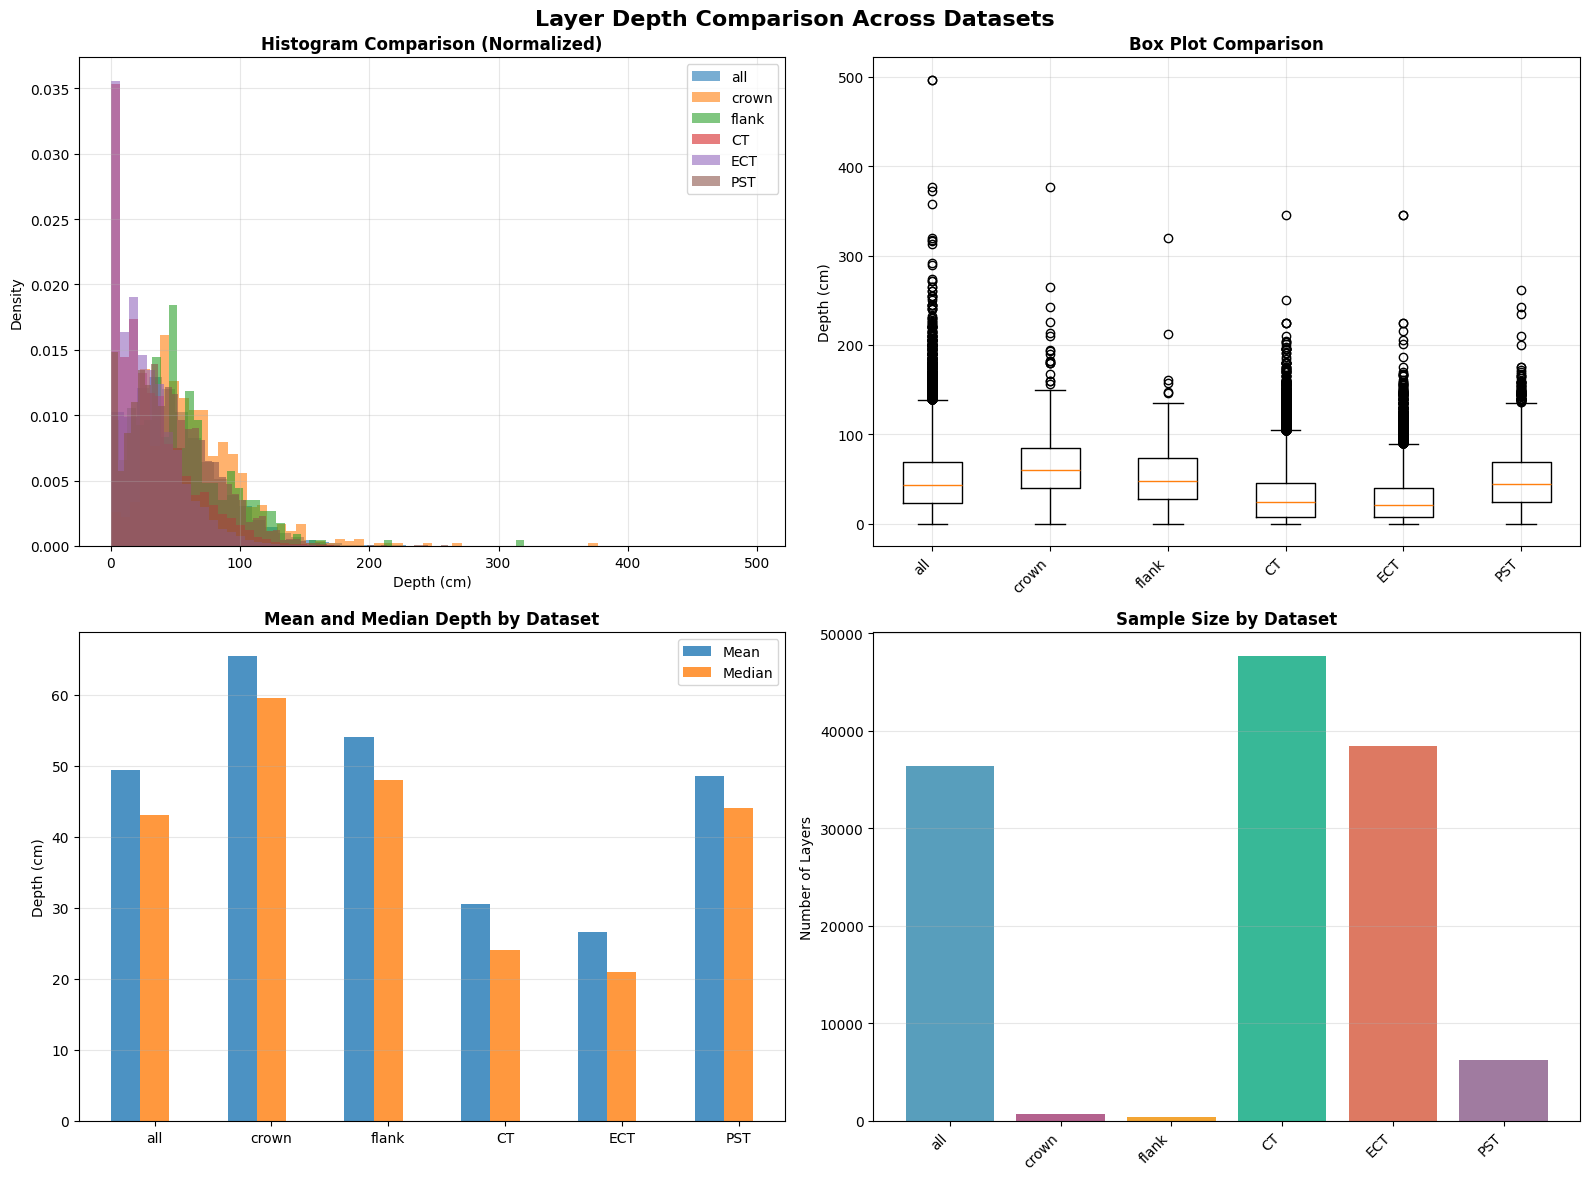

In [53]:
def analyze_depth(df, dataset_name):
    """Analyze depth statistics for a dataset."""
    valid_depth = df[df['depth_top'].notna()]['depth_top']
    stats = {
        'dataset': dataset_name,
        'total_layers': len(df),
        'layers_with_depth': len(valid_depth),
        'mean': valid_depth.mean() if len(valid_depth) > 0 else None,
        'median': valid_depth.median() if len(valid_depth) > 0 else None,
        'max': valid_depth.max() if len(valid_depth) > 0 else None,
        'min': valid_depth.min() if len(valid_depth) > 0 else None,
        'std': valid_depth.std() if len(valid_depth) > 0 else None,
    }
    return stats, valid_depth

def compare_depth_across_datasets(all_datasets_df):
    """Compare depth statistics and create visualizations across datasets."""
    datasets = {
        'all': all_datasets_df[all_datasets_df['dataset'] == 'all'],
        'crown': all_datasets_df[all_datasets_df['dataset'] == 'crown'],
        'flank': all_datasets_df[all_datasets_df['dataset'] == 'flank'],
        'CT': all_datasets_df[all_datasets_df['dataset'] == 'CT'],
        'ECT': all_datasets_df[all_datasets_df['dataset'] == 'ECT'],
        'PST': all_datasets_df[all_datasets_df['dataset'] == 'PST']
    }
    
    # Calculate statistics
    stats_list = []
    depth_data = {}
    for name, df in datasets.items():
        stats, depths = analyze_depth(df, name)
        stats_list.append(stats)
        depth_data[name] = depths
    
    stats_df = pd.DataFrame(stats_list)
    print("="*80)
    print("DEPTH STATISTICS COMPARISON")
    print("="*80)
    print(stats_df.to_string(index=False))
    
    # Create comparison visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Layer Depth Comparison Across Datasets', fontsize=16, fontweight='bold')
    
    # Histogram comparison
    for name, depths in depth_data.items():
        if len(depths) > 0:
            axes[0, 0].hist(depths, bins=50, alpha=0.6, label=name, density=True)
    axes[0, 0].set_title('Histogram Comparison (Normalized)', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Depth (cm)')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Box plot comparison
    depth_list = [depths.values for depths in depth_data.values() if len(depths) > 0]
    labels_list = [name for name, depths in depth_data.items() if len(depths) > 0]
    axes[0, 1].boxplot(depth_list, tick_labels=labels_list)
    axes[0, 1].set_title('Box Plot Comparison', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Depth (cm)')
    axes[0, 1].set_xticklabels(labels_list, rotation=45, ha='right')
    axes[0, 1].grid(alpha=0.3)
    
    # Statistics bar chart
    x = np.arange(len(stats_df))
    width = 0.25
    axes[1, 0].bar(x - width, stats_df['mean'], width, label='Mean', alpha=0.8)
    axes[1, 0].bar(x, stats_df['median'], width, label='Median', alpha=0.8)
    axes[1, 0].set_title('Mean and Median Depth by Dataset', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Depth (cm)')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(stats_df['dataset'])
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3, axis='y')
    
    # Sample size comparison
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#06A77D', '#D5573B', '#885A89']
    axes[1, 1].bar(stats_df['dataset'], stats_df['layers_with_depth'], alpha=0.8, color=colors[:len(stats_df)])
    axes[1, 1].set_title('Sample Size by Dataset', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Number of Layers')
    axes[1, 1].set_xticklabels(stats_df['dataset'], rotation=45, ha='right')
    axes[1, 1].grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    return stats_df

# Perform comparison analysis
depth_stats = compare_depth_across_datasets(all_datasets_df)


THICKNESS STATISTICS COMPARISON
dataset  total_layers  layers_with_thickness      mean  median   max  min       std
    all         36409                  36409 13.085122     8.0 250.0 0.01 14.427496
  crown           715                    715  9.813776     5.0 111.0 0.10 12.696035
  flank           356                    356 13.051124     8.0  80.0 0.10 14.226350
     CT         47702                  47702 19.136756    15.0 300.0 0.10 16.309655
    ECT         38400                  38400 16.628709    14.0 270.0 0.05 14.116905
    PST          6199                   6199 16.726964    13.0 205.0 0.20 15.673884


/var/folders/ft/ml81yv0j2v39f8t4xlgfn9h40000gn/T/ipykernel_16565/1483072611.py:81: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



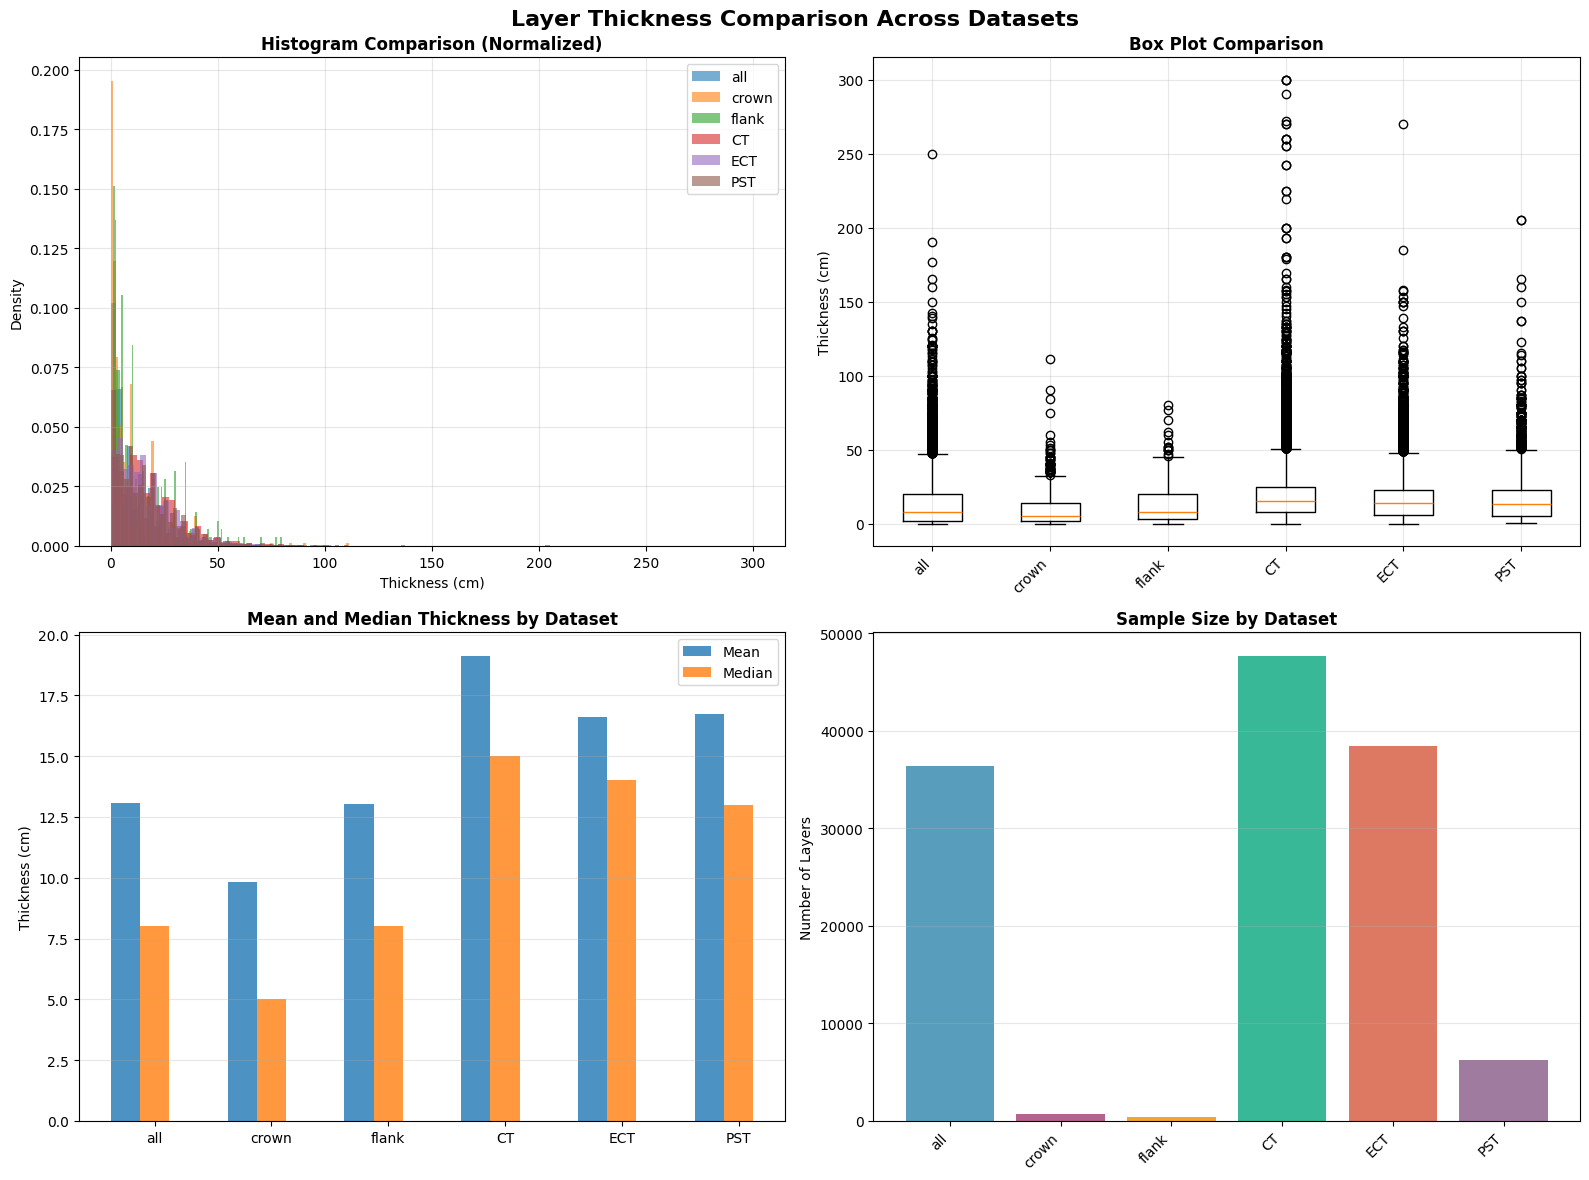

In [54]:
def analyze_thickness(df, dataset_name):
    """Analyze thickness statistics for a dataset."""
    valid_thickness = df[df['thickness'].notna()]['thickness']
    stats = {
        'dataset': dataset_name,
        'total_layers': len(df),
        'layers_with_thickness': len(valid_thickness),
        'mean': valid_thickness.mean() if len(valid_thickness) > 0 else None,
        'median': valid_thickness.median() if len(valid_thickness) > 0 else None,
        'max': valid_thickness.max() if len(valid_thickness) > 0 else None,
        'min': valid_thickness.min() if len(valid_thickness) > 0 else None,
        'std': valid_thickness.std() if len(valid_thickness) > 0 else None,
    }
    return stats, valid_thickness

def compare_thickness_across_datasets(all_datasets_df):
    """Compare thickness statistics and create visualizations across datasets."""
    datasets = {
        'all': all_datasets_df[all_datasets_df['dataset'] == 'all'],
        'crown': all_datasets_df[all_datasets_df['dataset'] == 'crown'],
        'flank': all_datasets_df[all_datasets_df['dataset'] == 'flank'],
        'CT': all_datasets_df[all_datasets_df['dataset'] == 'CT'],
        'ECT': all_datasets_df[all_datasets_df['dataset'] == 'ECT'],
        'PST': all_datasets_df[all_datasets_df['dataset'] == 'PST']
    }
    
    # Calculate statistics
    stats_list = []
    thickness_data = {}
    for name, df in datasets.items():
        stats, thicknesses = analyze_thickness(df, name)
        stats_list.append(stats)
        thickness_data[name] = thicknesses
    
    stats_df = pd.DataFrame(stats_list)
    print("="*80)
    print("THICKNESS STATISTICS COMPARISON")
    print("="*80)
    print(stats_df.to_string(index=False))
    
    # Create comparison visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Layer Thickness Comparison Across Datasets', fontsize=16, fontweight='bold')
    
    # Histogram comparison
    for name, thicknesses in thickness_data.items():
        if len(thicknesses) > 0:
            axes[0, 0].hist(thicknesses, bins=100, alpha=0.6, label=name, density=True)
    axes[0, 0].set_title('Histogram Comparison (Normalized)', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Thickness (cm)')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Box plot comparison
    thickness_list = [thicknesses.values for thicknesses in thickness_data.values() if len(thicknesses) > 0]
    labels_list = [name for name, thicknesses in thickness_data.items() if len(thicknesses) > 0]
    axes[0, 1].boxplot(thickness_list, tick_labels=labels_list)
    axes[0, 1].set_title('Box Plot Comparison', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Thickness (cm)')
    axes[0, 1].set_xticklabels(labels_list, rotation=45, ha='right')
    axes[0, 1].grid(alpha=0.3)
    
    # Statistics bar chart
    x = np.arange(len(stats_df))
    width = 0.25
    axes[1, 0].bar(x - width, stats_df['mean'], width, label='Mean', alpha=0.8)
    axes[1, 0].bar(x, stats_df['median'], width, label='Median', alpha=0.8)
    axes[1, 0].set_title('Mean and Median Thickness by Dataset', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Thickness (cm)')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(stats_df['dataset'])
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3, axis='y')
    
    # Sample size comparison
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#06A77D', '#D5573B', '#885A89']
    axes[1, 1].bar(stats_df['dataset'], stats_df['layers_with_thickness'], alpha=0.8, color=colors[:len(stats_df)])
    axes[1, 1].set_title('Sample Size by Dataset', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Number of Layers')
    axes[1, 1].set_xticklabels(stats_df['dataset'], rotation=45, ha='right')
    axes[1, 1].grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    return stats_df

# Perform comparison analysis
thickness_stats = compare_thickness_across_datasets(all_datasets_df)


HARDNESS STATISTICS COMPARISON
dataset  total_layers  layers_with_hardness  layers_with_numeric_hardness  percentage  mean_numeric  median_numeric  min_numeric  max_numeric  std_numeric
    all         36409                 33114                         32721   90.950040      2.119712            2.00         0.67         5.33     1.190894
  crown           715                   662                           658   92.587413      1.861018            1.67         0.67         5.33     0.992474
  flank           356                   326                           324   91.573034      1.963086            2.00         0.67         5.00     1.092359
     CT         47702                 42054                         41825   88.159826      2.361184            2.00         0.67         5.33     1.116566
    ECT         38400                 33513                         33334   87.273438      2.314503            2.00         0.67         5.33     1.106544
    PST          6199                  

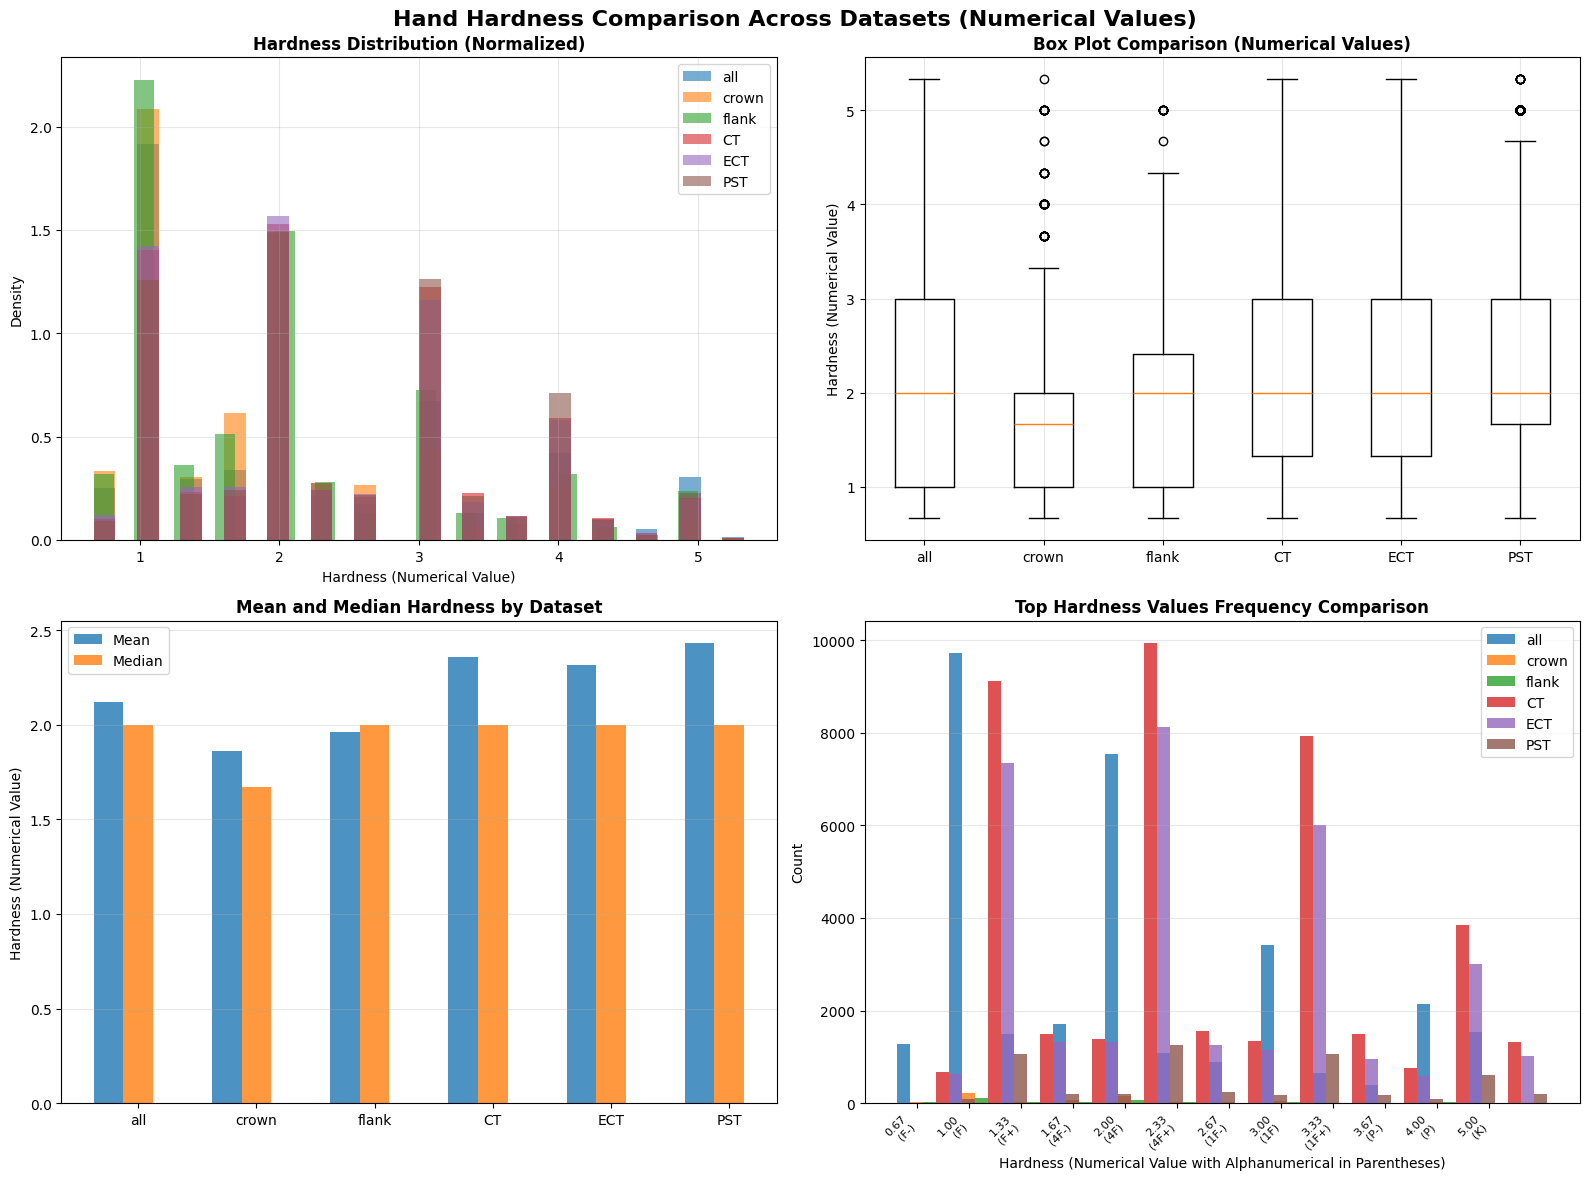

/var/folders/ft/ml81yv0j2v39f8t4xlgfn9h40000gn/T/ipykernel_16565/847267973.py:196: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



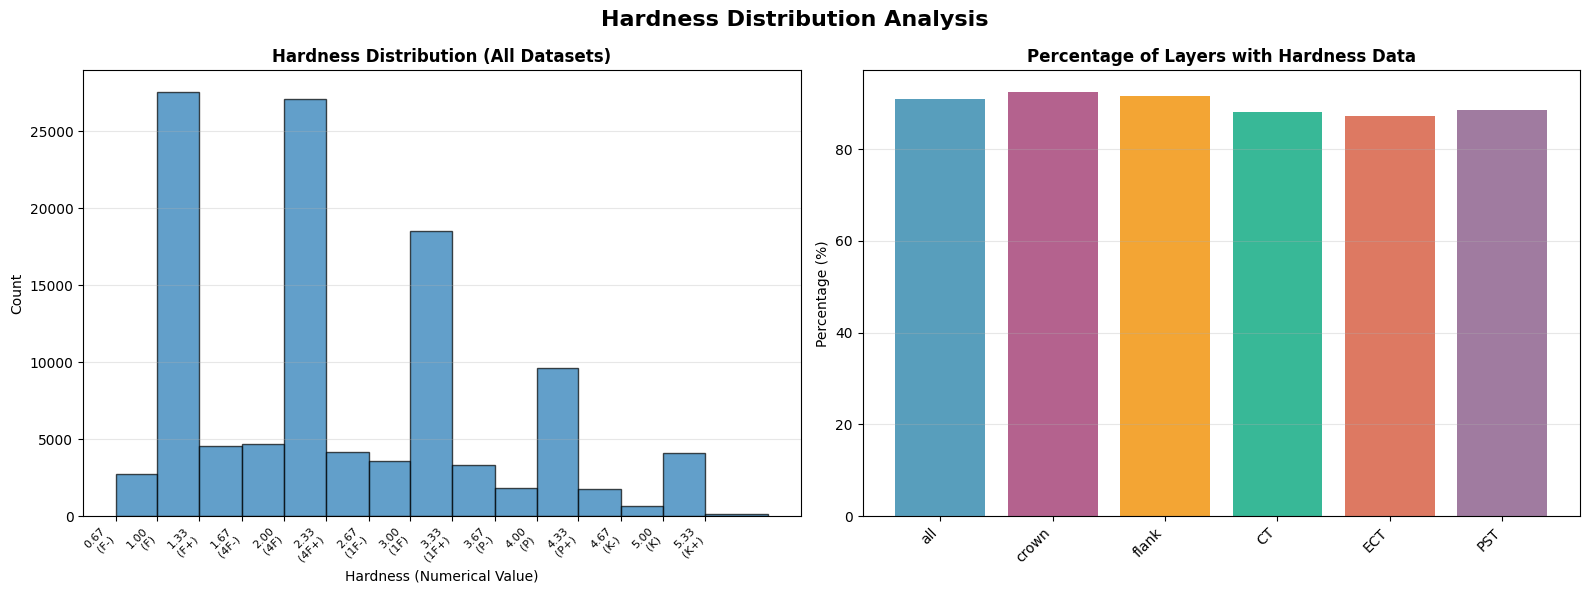

In [55]:
# Hand hardness mapping to numerical values
HARDNESS_MAPPING = {
    'F-': 0.67, 'F': 1.0, 'F+': 1.33,
    '4F-': 1.67, '4F': 2.0, '4F+': 2.33,
    '1F-': 2.67, '1F': 3.0, '1F+': 3.33,
    'P-': 3.67, 'P': 4.0, 'P+': 4.33,
    'K-': 4.67, 'K': 5.0, 'K+': 5.33
}

def map_hardness_to_numeric(hardness_str):
    """Convert alphanumerical hardness to numerical value."""
    if pd.isna(hardness_str):
        return None
    return HARDNESS_MAPPING.get(str(hardness_str), None)

def analyze_hardness(df, dataset_name):
    """Analyze hardness statistics for a dataset."""
    valid_hardness = df[df['hardness'].notna()]['hardness']
    
    # Convert to numerical values
    df_with_numeric = df[df['hardness'].notna()].copy()
    df_with_numeric['hardness_numeric'] = df_with_numeric['hardness'].apply(map_hardness_to_numeric)
    valid_hardness_numeric = df_with_numeric[df_with_numeric['hardness_numeric'].notna()]['hardness_numeric']
    
    stats = {
        'dataset': dataset_name,
        'total_layers': len(df),
        'layers_with_hardness': len(valid_hardness),
        'layers_with_numeric_hardness': len(valid_hardness_numeric),
        'percentage': len(valid_hardness) / len(df) * 100 if len(df) > 0 else 0,
        'mean_numeric': valid_hardness_numeric.mean() if len(valid_hardness_numeric) > 0 else None,
        'median_numeric': valid_hardness_numeric.median() if len(valid_hardness_numeric) > 0 else None,
        'min_numeric': valid_hardness_numeric.min() if len(valid_hardness_numeric) > 0 else None,
        'max_numeric': valid_hardness_numeric.max() if len(valid_hardness_numeric) > 0 else None,
        'std_numeric': valid_hardness_numeric.std() if len(valid_hardness_numeric) > 0 else None,
    }
    return stats, valid_hardness, valid_hardness_numeric

def compare_hardness_across_datasets(all_datasets_df):
    """Compare hardness statistics and create visualizations across datasets."""
    datasets = {
        'all': all_datasets_df[all_datasets_df['dataset'] == 'all'],
        'crown': all_datasets_df[all_datasets_df['dataset'] == 'crown'],
        'flank': all_datasets_df[all_datasets_df['dataset'] == 'flank'],
        'CT': all_datasets_df[all_datasets_df['dataset'] == 'CT'],
        'ECT': all_datasets_df[all_datasets_df['dataset'] == 'ECT'],
        'PST': all_datasets_df[all_datasets_df['dataset'] == 'PST']
    }
    
    # Calculate statistics
    stats_list = []
    hardness_data = {}
    hardness_numeric_data = {}
    for name, df in datasets.items():
        stats, hardnesses, hardnesses_numeric = analyze_hardness(df, name)
        stats_list.append(stats)
        hardness_data[name] = hardnesses
        hardness_numeric_data[name] = hardnesses_numeric
    
    stats_df = pd.DataFrame(stats_list)
    print("="*80)
    print("HARDNESS STATISTICS COMPARISON")
    print("="*80)
    print(stats_df.to_string(index=False))
    
    # Frequency counts for each dataset (alphanumerical)
    print("\n" + "="*80)
    print("HARDNESS FREQUENCY BY DATASET (Alphanumerical)")
    print("="*80)
    for name, hardnesses in hardness_data.items():
        if len(hardnesses) > 0:
            print(f"\n{name.upper()}:")
            print(hardnesses.value_counts().head(10))
    
    # Create comparison visualizations based on numerical values
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Hand Hardness Comparison Across Datasets (Numerical Values)', fontsize=16, fontweight='bold')
    
    # Histogram comparison using numerical values
    for name, hardnesses_numeric in hardness_numeric_data.items():
        if len(hardnesses_numeric) > 0:
            axes[0, 0].hist(hardnesses_numeric, bins=30, alpha=0.6, label=name, density=True)
    axes[0, 0].set_title('Hardness Distribution (Normalized)', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Hardness (Numerical Value)')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Box plot comparison using numerical values
    hardness_numeric_list = [h.values for h in hardness_numeric_data.values() if len(h) > 0]
    labels_list = [name for name, h in hardness_numeric_data.items() if len(h) > 0]
    bp = axes[0, 1].boxplot(hardness_numeric_list, tick_labels=labels_list)
    axes[0, 1].set_title('Box Plot Comparison (Numerical Values)', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Hardness (Numerical Value)')
    axes[0, 1].grid(alpha=0.3)
    
    # Statistics bar chart (mean and median)
    x = np.arange(len(stats_df))
    width = 0.25
    axes[1, 0].bar(x - width, stats_df['mean_numeric'], width, label='Mean', alpha=0.8)
    axes[1, 0].bar(x, stats_df['median_numeric'], width, label='Median', alpha=0.8)
    axes[1, 0].set_title('Mean and Median Hardness by Dataset', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Hardness (Numerical Value)')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(stats_df['dataset'])
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3, axis='y')
    
    # Frequency comparison for top hardness values (with alphanumerical labels)
    # Get all unique hardness values and their numeric equivalents
    all_hardness_values = set()
    for hardnesses in hardness_data.values():
        all_hardness_values.update(hardnesses.value_counts().head(10).index)
    
    # Sort by numerical value
    hardness_with_numeric = [(h, map_hardness_to_numeric(h)) for h in all_hardness_values]
    hardness_with_numeric = [(h, num) for h, num in hardness_with_numeric if num is not None]
    hardness_with_numeric.sort(key=lambda x: x[1])
    sorted_hardness_values = [h for h, _ in hardness_with_numeric]
    
    x = np.arange(len(sorted_hardness_values))
    width = 0.25
    for i, (name, hardnesses) in enumerate(hardness_data.items()):
        if len(hardnesses) > 0:
            counts = [hardnesses.value_counts().get(val, 0) for val in sorted_hardness_values]
            axes[1, 1].bar(x + i*width, counts, width, label=name, alpha=0.8)
    
    # Create labels with numerical value and alphanumerical in parentheses
    labels = []
    for h in sorted_hardness_values:
        num_val = map_hardness_to_numeric(h)
        labels.append(f'{num_val:.2f}\n({h})')
    
    axes[1, 1].set_title('Top Hardness Values Frequency Comparison', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Hardness (Numerical Value with Alphanumerical in Parentheses)')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_xticks(x + width)
    axes[1, 1].set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Additional visualization: Distribution by numerical value with alphanumerical labels
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Hardness Distribution Analysis', fontsize=16, fontweight='bold')
    
    # Create a combined histogram with alphanumerical labels on x-axis
    # Group by numerical value ranges
    all_numeric_hardness = []
    all_alphanumeric_hardness = []
    for name, hardnesses in hardness_data.items():
        df_temp = datasets[name][datasets[name]['hardness'].notna()].copy()
        df_temp['hardness_numeric'] = df_temp['hardness'].apply(map_hardness_to_numeric)
        df_temp = df_temp[df_temp['hardness_numeric'].notna()]
        all_numeric_hardness.extend(df_temp['hardness_numeric'].tolist())
        all_alphanumeric_hardness.extend(df_temp['hardness'].tolist())
    
    # Create bins based on unique numerical values
    unique_numeric_values = sorted(set(all_numeric_hardness))
    bins = unique_numeric_values + [unique_numeric_values[-1] + 0.5]  # Add upper edge
    
    # Create mapping from numeric to alphanumeric for labels
    numeric_to_alphanumeric = {}
    for h_str, h_num in HARDNESS_MAPPING.items():
        if h_num in unique_numeric_values:
            if h_num not in numeric_to_alphanumeric:
                numeric_to_alphanumeric[h_num] = []
            numeric_to_alphanumeric[h_num].append(h_str)
    
    # Histogram
    axes[0].hist(all_numeric_hardness, bins=bins, alpha=0.7, edgecolor='black')
    axes[0].set_title('Hardness Distribution (All Datasets)', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Hardness (Numerical Value)')
    axes[0].set_ylabel('Count')
    axes[0].grid(alpha=0.3, axis='y')
    
    # Add alphanumerical labels below x-axis
    tick_positions = unique_numeric_values
    tick_labels = []
    for pos in tick_positions:
        if pos in numeric_to_alphanumeric:
            alphanum = '/'.join(numeric_to_alphanumeric[pos])
            tick_labels.append(f'{pos:.2f}\n({alphanum})')
        else:
            tick_labels.append(f'{pos:.2f}')
    axes[0].set_xticks(tick_positions)
    axes[0].set_xticklabels(tick_labels, rotation=45, ha='right', fontsize=8)
    
    # Percentage with hardness data
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#06A77D', '#D5573B', '#885A89']
    axes[1].bar(stats_df['dataset'], stats_df['percentage'], alpha=0.8, color=colors[:len(stats_df)])
    axes[1].set_title('Percentage of Layers with Hardness Data', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Percentage (%)')
    axes[1].set_xticklabels(stats_df['dataset'], rotation=45, ha='right')
    axes[1].grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    return stats_df

# Perform comparison analysis
hardness_stats = compare_hardness_across_datasets(all_datasets_df)


/var/folders/ft/ml81yv0j2v39f8t4xlgfn9h40000gn/T/ipykernel_16565/735788229.py:75: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ft/ml81yv0j2v39f8t4xlgfn9h40000gn/T/ipykernel_16565/735788229.py:82: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ft/ml81yv0j2v39f8t4xlgfn9h40000gn/T/ipykernel_16565/735788229.py:100: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



WETNESS STATISTICS COMPARISON
dataset  total_layers  layers_with_wetness  percentage
    all         36409                 9378   25.757368
  crown           715                  165   23.076923
  flank           356                   98   27.528090
     CT         47702                13663   28.642405
    ECT         38400                 8520   22.187500
    PST          6199                 1619   26.117116

WETNESS FREQUENCY BY DATASET

ALL:
wetness
D      7154
M       998
D-M     647
M-W     225
W       224
V        60
W-V      32
S        19
V-S      19
Name: count, dtype: int64

CROWN:
wetness
D      143
M       12
D-M      7
M-W      2
V        1
Name: count, dtype: int64

FLANK:
wetness
D      70
D-M    10
W       8
M       6
M-W     2
W-V     1
V-S     1
Name: count, dtype: int64

CT:
wetness
D      11188
M       1266
D-M      705
W        229
M-W      189
V         46
W-V       27
V-S        9
S          4
Name: count, dtype: int64

ECT:
wetness
D      6887
M       778
D-M 

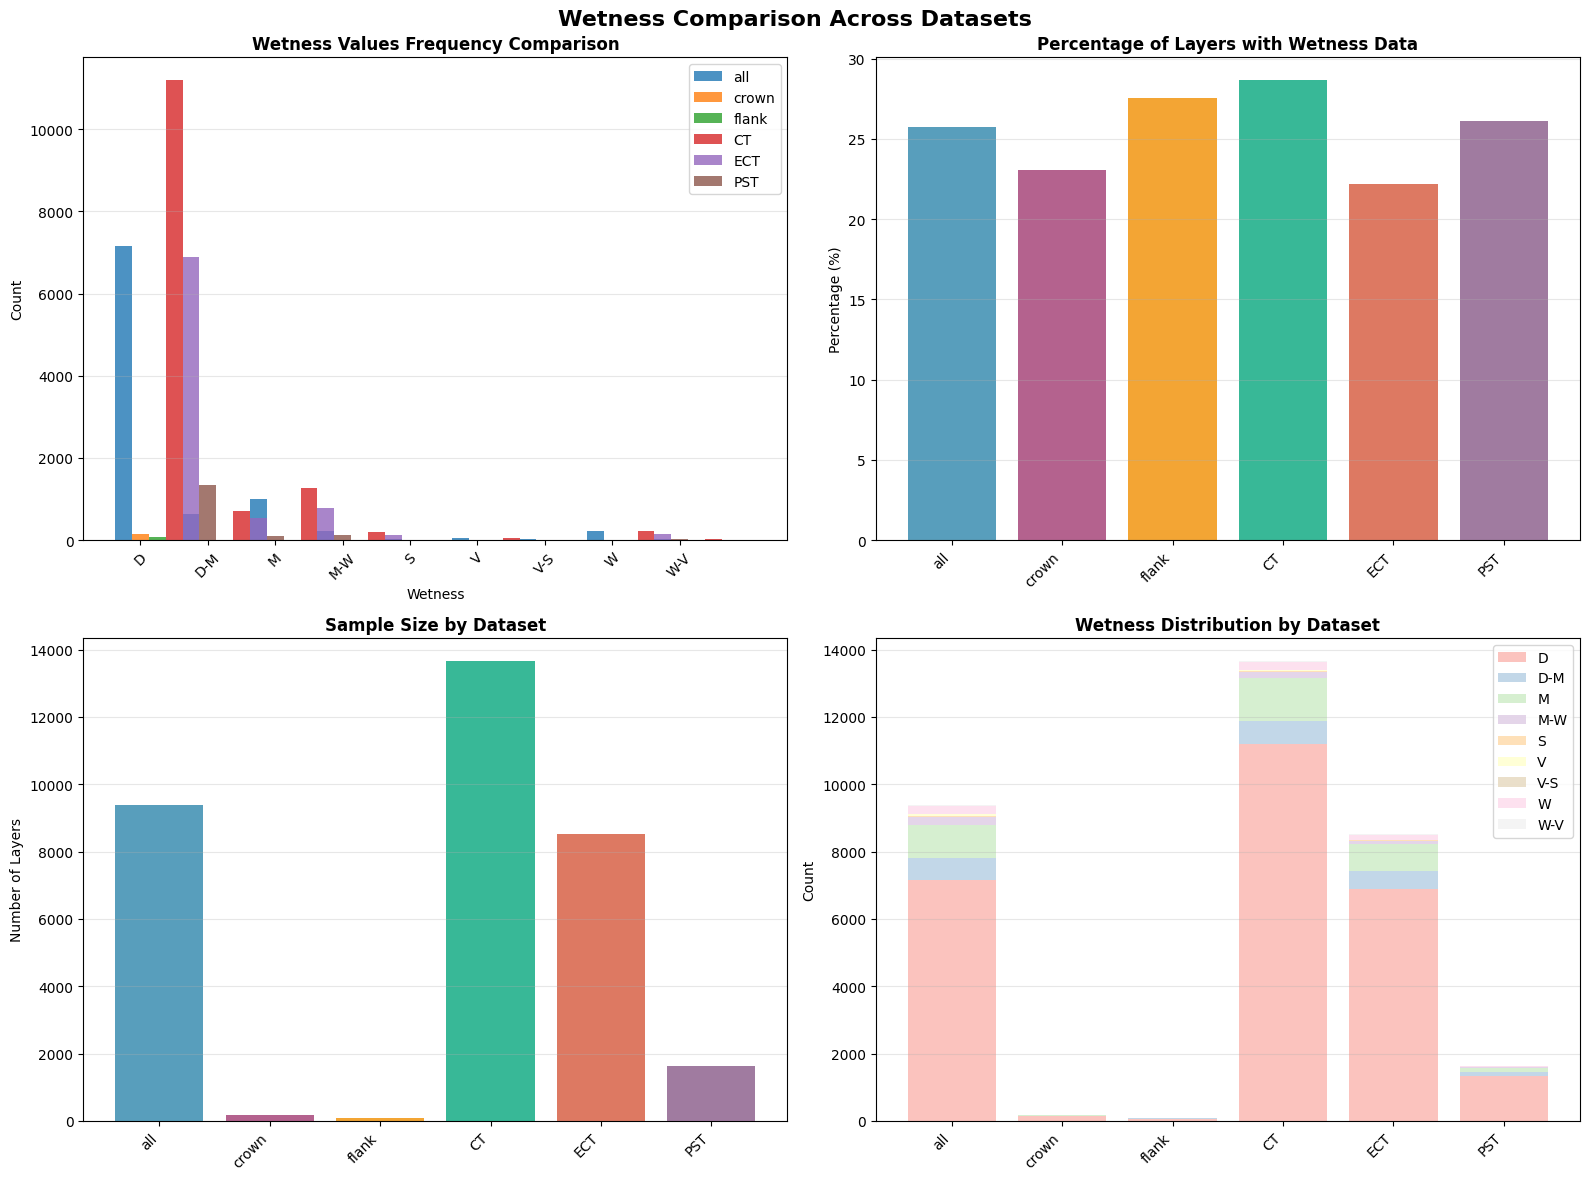

In [56]:
def analyze_wetness(df, dataset_name):
    """Analyze wetness statistics for a dataset."""
    valid_wetness = df[df['wetness'].notna()]['wetness']
    stats = {
        'dataset': dataset_name,
        'total_layers': len(df),
        'layers_with_wetness': len(valid_wetness),
        'percentage': len(valid_wetness) / len(df) * 100 if len(df) > 0 else 0,
    }
    return stats, valid_wetness

def compare_wetness_across_datasets(all_datasets_df):
    """Compare wetness statistics and create visualizations across datasets."""
    datasets = {
        'all': all_datasets_df[all_datasets_df['dataset'] == 'all'],
        'crown': all_datasets_df[all_datasets_df['dataset'] == 'crown'],
        'flank': all_datasets_df[all_datasets_df['dataset'] == 'flank'],
        'CT': all_datasets_df[all_datasets_df['dataset'] == 'CT'],
        'ECT': all_datasets_df[all_datasets_df['dataset'] == 'ECT'],
        'PST': all_datasets_df[all_datasets_df['dataset'] == 'PST']
    }
    
    # Calculate statistics
    stats_list = []
    wetness_data = {}
    for name, df in datasets.items():
        stats, wetnesses = analyze_wetness(df, name)
        stats_list.append(stats)
        wetness_data[name] = wetnesses
    
    stats_df = pd.DataFrame(stats_list)
    print("="*80)
    print("WETNESS STATISTICS COMPARISON")
    print("="*80)
    print(stats_df.to_string(index=False))
    
    # Frequency counts for each dataset
    print("\n" + "="*80)
    print("WETNESS FREQUENCY BY DATASET")
    print("="*80)
    for name, wetnesses in wetness_data.items():
        if len(wetnesses) > 0:
            print(f"\n{name.upper()}:")
            print(wetnesses.value_counts())
    
    # Create comparison visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Wetness Comparison Across Datasets', fontsize=16, fontweight='bold')
    
    # Frequency comparison for all wetness values
    all_wetness_values = set()
    for wetnesses in wetness_data.values():
        all_wetness_values.update(wetnesses.value_counts().index)
    all_wetness_values = sorted(list(all_wetness_values))
    
    x = np.arange(len(all_wetness_values))
    width = 0.25
    for i, (name, wetnesses) in enumerate(wetness_data.items()):
        if len(wetnesses) > 0:
            counts = [wetnesses.value_counts().get(val, 0) for val in all_wetness_values]
            axes[0, 0].bar(x + i*width, counts, width, label=name, alpha=0.8)
    axes[0, 0].set_title('Wetness Values Frequency Comparison', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Wetness')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_xticks(x + width)
    axes[0, 0].set_xticklabels(all_wetness_values, rotation=45)
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3, axis='y')
    
    # Percentage with wetness data
    colors_bar = ['#2E86AB', '#A23B72', '#F18F01', '#06A77D', '#D5573B', '#885A89']
    axes[0, 1].bar(stats_df['dataset'], stats_df['percentage'], alpha=0.8, color=colors_bar[:len(stats_df)])
    axes[0, 1].set_title('Percentage of Layers with Wetness Data', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Percentage (%)')
    axes[0, 1].set_xticklabels(stats_df['dataset'], rotation=45, ha='right')
    axes[0, 1].grid(alpha=0.3, axis='y')
    
    # Sample size comparison
    axes[1, 0].bar(stats_df['dataset'], stats_df['layers_with_wetness'], alpha=0.8, color=colors_bar[:len(stats_df)])
    axes[1, 0].set_title('Sample Size by Dataset', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Number of Layers')
    axes[1, 0].set_xticklabels(stats_df['dataset'], rotation=45, ha='right')
    axes[1, 0].grid(alpha=0.3, axis='y')
    
    # Stacked bar chart for wetness distribution
    dataset_names = list(datasets.keys())
    bottom = np.zeros(len(dataset_names))
    colors = plt.cm.Pastel1(np.linspace(0, 1, len(all_wetness_values)))
    for i, wetness_val in enumerate(all_wetness_values):
        values = []
        for name in dataset_names:
            if name in wetness_data and len(wetness_data[name]) > 0:
                values.append(wetness_data[name].value_counts().get(wetness_val, 0))
            else:
                values.append(0)
        axes[1, 1].bar(dataset_names, values, bottom=bottom, label=wetness_val, color=colors[i], alpha=0.8)
        bottom += values
    axes[1, 1].set_title('Wetness Distribution by Dataset', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_xticklabels(dataset_names, rotation=45, ha='right')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    return stats_df

# Perform comparison analysis
wetness_stats = compare_wetness_across_datasets(all_datasets_df)


GRAIN FORM STATISTICS COMPARISON
dataset  total_layers  layers_with_primary_grain_form  percentage_primary_grain_form  layers_with_primary_grain_size  percentage_primary_grain_size  layers_with_secondary_grain_form  percentage_secondary_grain_form
    all         36409                           33153                      91.057156                           22636                      62.171441                              6075                        16.685435
  crown           715                             679                      94.965035                             532                      74.405594                               134                        18.741259
  flank           356                             329                      92.415730                             233                      65.449438                                78                        21.910112
     CT         47702                           38488                      80.684248                       

/var/folders/ft/ml81yv0j2v39f8t4xlgfn9h40000gn/T/ipykernel_16565/1387161486.py:115: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ft/ml81yv0j2v39f8t4xlgfn9h40000gn/T/ipykernel_16565/1387161486.py:123: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



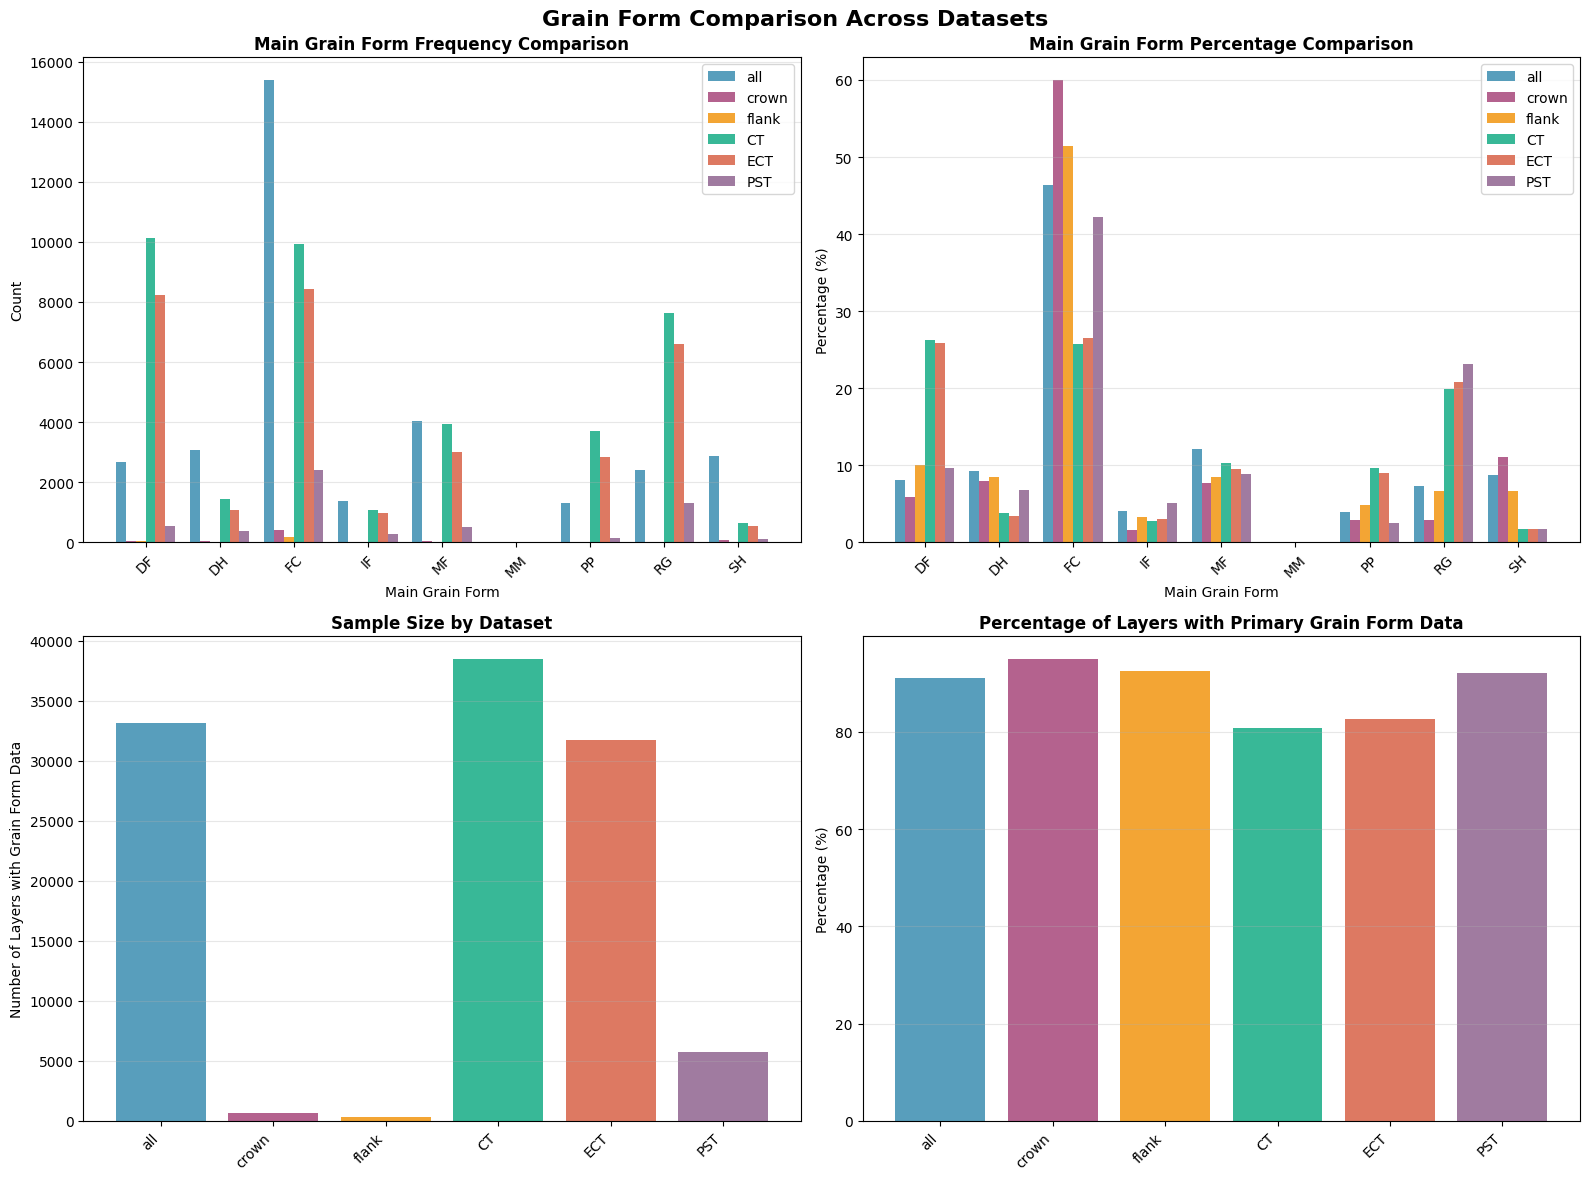

In [ ]:
def analyze_grain_forms(df, dataset_name):
    """Analyze grain form statistics for a dataset."""
    valid_grain_form = df[df['grain_form_primary_grain_form'].notna()]
    valid_grain_size = df[df['grain_from_primary_grain_size'].notna()]
    valid_secondary = df[df['grain_form_secondary_grain_form'].notna()]
    
    stats = {
        'dataset': dataset_name,
        'total_layers': len(df),
        'layers_with_primary_grain_form': len(valid_grain_form),
        'percentage_primary_grain_form': len(valid_grain_form) / len(df) * 100 if len(df) > 0 else 0,
        'layers_with_primary_grain_size': len(valid_grain_size),
        'percentage_primary_grain_size': len(valid_grain_size) / len(df) * 100 if len(df) > 0 else 0,
        'layers_with_secondary_grain_form': len(valid_secondary),
        'percentage_secondary_grain_form': len(valid_secondary) / len(df) * 100 if len(df) > 0 else 0,
    }
    return stats, valid_grain_form

def compare_grain_forms_across_datasets(all_datasets_df):
    """Compare grain form statistics and create visualizations across datasets."""
    datasets = {
        'all': all_datasets_df[all_datasets_df['dataset'] == 'all'],
        'crown': all_datasets_df[all_datasets_df['dataset'] == 'crown'],
        'flank': all_datasets_df[all_datasets_df['dataset'] == 'flank']
    }
    
    # Calculate statistics
    stats_list = []
    grain_form_data = {}
    for name, df in datasets.items():
        stats, valid_grain = analyze_grain_forms(df, name)
        stats_list.append(stats)
        grain_form_data[name] = valid_grain
    
    stats_df = pd.DataFrame(stats_list)
    print("="*80)
    print("GRAIN FORM STATISTICS COMPARISON")
    print("="*80)
    print(stats_df.to_string(index=False))
    
    # Main grain form analysis (first 2 characters)
    print("\n" + "="*80)
    print("MAIN GRAIN FORM (FIRST 2 CHARACTERS) COMPARISON")
    print("="*80)
    
    # Calculate main grain form frequencies for each dataset
    main_grain_stats = {}
    for name, df in grain_form_data.items():
        if len(df) > 0:
            df_copy = df.copy()
            df_copy['main_grain_form'] = df_copy['grain_form_primary_grain_form'].str[:2]
            main_counts = df_copy['main_grain_form'].value_counts()
            main_percentages = df_copy['main_grain_form'].value_counts(normalize=True) * 100
            main_grain_stats[name] = {
                'counts': main_counts,
                'percentages': main_percentages
            }
            print(f"\n{name.upper()}:")
            main_stats_df = pd.DataFrame({
                'Count': main_counts,
                'Percentage': main_percentages
            })
            main_stats_df['Percentage'] = main_stats_df['Percentage'].apply(lambda x: f'{x:.2f}%')
            print(main_stats_df)
    
    # Create comparison visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Grain Form Comparison Across Datasets', fontsize=16, fontweight='bold')
    
    # Get all main grain forms across datasets
    all_main_grain_forms = set()
    for stats in main_grain_stats.values():
        all_main_grain_forms.update(stats['counts'].index)
    all_main_grain_forms = sorted(list(all_main_grain_forms))
    
    # Side-by-side comparison of main grain forms
    x = np.arange(len(all_main_grain_forms))
    width = 0.25
    colors = ['#2E86AB', '#A23B72', '#F18F01']
    for i, (name, stats) in enumerate(main_grain_stats.items()):
        counts = [stats['counts'].get(gf, 0) for gf in all_main_grain_forms]
        axes[0, 0].bar(x + i*width, counts, width, label=name, color=colors[i], alpha=0.8)
    axes[0, 0].set_title('Main Grain Form Frequency Comparison', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Main Grain Form')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_xticks(x + width)
    axes[0, 0].set_xticklabels(all_main_grain_forms, rotation=45)
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3, axis='y')
    
    # Percentage comparison
    for i, (name, stats) in enumerate(main_grain_stats.items()):
        percentages = [stats['percentages'].get(gf, 0) for gf in all_main_grain_forms]
        axes[0, 1].bar(x + i*width, percentages, width, label=name, color=colors[i], alpha=0.8)
    axes[0, 1].set_title('Main Grain Form Percentage Comparison', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Main Grain Form')
    axes[0, 1].set_ylabel('Percentage (%)')
    axes[0, 1].set_xticks(x + width)
    axes[0, 1].set_xticklabels(all_main_grain_forms, rotation=45)
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3, axis='y')
    
    # Sample size comparison
    axes[1, 0].bar(stats_df['dataset'], stats_df['layers_with_primary_grain_form'], 
                   alpha=0.8, color=['#2E86AB', '#A23B72', '#F18F01'])
    axes[1, 0].set_title('Sample Size by Dataset', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Number of Layers with Grain Form Data')
    axes[1, 0].grid(alpha=0.3, axis='y')
    
    # Percentage with grain form data
    axes[1, 1].bar(stats_df['dataset'], stats_df['percentage_primary_grain_form'], 
                   alpha=0.8, color=['#2E86AB', '#A23B72', '#F18F01'])
    axes[1, 1].set_title('Percentage of Layers with Primary Grain Form Data', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Percentage (%)')
    axes[1, 1].grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    return stats_df, main_grain_stats

# Perform comparison analysis
grain_form_stats, main_grain_stats = compare_grain_forms_across_datasets(all_datasets_df)


## Summary of Analysis Results

The analysis above compares layers of concern across all datasets (all identified layers, pits on crowns, and pits on flanks). All analyses have been refactored to be efficient and provide direct comparisons across datasets.

## Stability Test Failure Layers Analysis

This section extracts and analyzes layers where stability tests (CT, ECT, PST) failed, matching test failure depths to corresponding snow layers.

In [61]:
# Note: Stability test failure layers are now extracted at the top of the notebook (Cell 5)
# and added to the layers of concern dataset with dataset names as test types (CT, ECT, PST).
# The failure layers are available in all_failure_layers_df.

# Create a version of the failure layers data with test_type column for analysis
# Extract failure layers from the combined dataset
failure_layers_for_analysis = all_failure_layers_df.copy()
failure_layers_for_analysis['test_type'] = failure_layers_for_analysis['dataset']  # dataset is already the test type

print("Stability Test Failure Layers Summary:")
print(f"  Total failure layers: {len(failure_layers_for_analysis)}")
print(f"  CT failures: {len(failure_layers_for_analysis[failure_layers_for_analysis['dataset'] == 'CT'])}")
print(f"  ECT failures: {len(failure_layers_for_analysis[failure_layers_for_analysis['dataset'] == 'ECT'])}")
print(f"  PST failures: {len(failure_layers_for_analysis[failure_layers_for_analysis['dataset'] == 'PST'])}")
print(f"\nSample of failure layers data:")
print(failure_layers_for_analysis.head() if len(failure_layers_for_analysis) > 0 else "No failure layers found")


Stability Test Failure Layers Summary:
  Total failure layers: 92301
  CT failures: 47702
  ECT failures: 38400
  PST failures: 6199

Sample of failure layers data:
  pit_id dataset  depth_top  thickness hardness wetness  \
0   9544      CT       14.0       24.0       1F       W   
1  43746      CT        2.0       30.0       1F       D   
2  18792      CT       92.0       30.0       4F    None   
3  18792      CT       76.0       16.0       1F    None   
4  18792      CT       47.0       29.0      4F-    None   

  grain_form_primary_grain_form  grain_from_primary_grain_size  \
0                          MFpc                            2.0   
1                            DF                            0.5   
2                          None                            NaN   
3                          MFcr                            NaN   
4                          None                            NaN   

  grain_form_secondary_grain_form grain_from_secondary_grain_size test_type  
0    

In [62]:
# Basic analysis of failure layers
if len(failure_layers_for_analysis) > 0:
    print("="*80)
    print("FAILURE LAYERS ANALYSIS BY TEST TYPE")
    print("="*80)
    
    # Count by test type
    summary = failure_layers_for_analysis.groupby('test_type').size()
    print("\nCount of Failure Layers by Test Type:")
    print(summary)
    
    # Percentage breakdown
    print("\nPercentage Breakdown:")
    total = len(failure_layers_for_analysis)
    for test_type in ['CT', 'ECT', 'PST']:
        count = len(failure_layers_for_analysis[failure_layers_for_analysis['test_type'] == test_type])
        if count > 0:
            print(f"  {test_type}: {count} ({count/total*100:.2f}%)")
    
    # Check overlap with identified layers of concern from the combined dataset
    # Match failure layers with layers of concern by pit_id, depth_top, and thickness
    print("\n" + "="*80)
    print("OVERLAP WITH IDENTIFIED LAYERS OF CONCERN")
    print("="*80)
    
    # Get layers of concern from the combined dataset (excluding stability test datasets)
    layers_of_concern_df = all_datasets_df[all_datasets_df['dataset'].isin(['all', 'crown', 'flank'])].copy()
    
    # Merge on pit_id, depth_top, and thickness to find overlaps
    merged = failure_layers_for_analysis.merge(
        layers_of_concern_df[['pit_id', 'depth_top', 'thickness']],
        on=['pit_id', 'depth_top', 'thickness'],
        how='inner',
        suffixes=('_failure', '_loc')
    )
    
    if len(merged) > 0:
        print(f"\nFailure layers that match identified layers of concern: {len(merged)} ({len(merged)/len(failure_layers_for_analysis)*100:.2f}%)")
        loc_summary = merged.groupby('test_type').size()
        print("\nBreakdown by Test Type:")
        print(loc_summary)
    else:
        print("\nNo exact matches found between failure layers and identified layers of concern.")
        print("(Note: This checks for exact matches on pit_id, depth_top, and thickness)")
else:
    print("No failure layers found in the dataset.")


FAILURE LAYERS ANALYSIS BY TEST TYPE

Count of Failure Layers by Test Type:
test_type
CT     47702
ECT    38400
PST     6199
dtype: int64

Percentage Breakdown:
  CT: 47702 (51.68%)
  ECT: 38400 (41.60%)
  PST: 6199 (6.72%)

OVERLAP WITH IDENTIFIED LAYERS OF CONCERN

Failure layers that match identified layers of concern: 20189 (21.87%)

Breakdown by Test Type:
test_type
CT     9636
ECT    8631
PST    1922
dtype: int64
